In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,ReLU,Flatten,Input
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('household_power_consumption.txt',delimiter = ';',parse_dates = ['Date'],dayfirst=True,low_memory=False)

In [ ]:
data

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2075255,2010-11-26,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2075256,2010-11-26,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,2010-11-26,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0


Pre-processing the data

In [ ]:
print(data.columns)

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')


In [ ]:
data['DateTime'] = data['Date'].astype(str) + ' ' + data['Time'].astype(str)

data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M:%S')

data.set_index('DateTime', inplace=True)

print(data.head())

data.replace('?', np.nan, inplace=True)
data.ffill(inplace=True)

                          Date      Time Global_active_power  \
DateTime                                                       
2006-12-16 17:24:00 2006-12-16  17:24:00               4.216   
2006-12-16 17:25:00 2006-12-16  17:25:00               5.360   
2006-12-16 17:26:00 2006-12-16  17:26:00               5.374   
2006-12-16 17:27:00 2006-12-16  17:27:00               5.388   
2006-12-16 17:28:00 2006-12-16  17:28:00               3.666   

                    Global_reactive_power  Voltage Global_intensity  \
DateTime                                                              
2006-12-16 17:24:00                 0.418  234.840           18.400   
2006-12-16 17:25:00                 0.436  233.630           23.000   
2006-12-16 17:26:00                 0.498  233.290           23.000   
2006-12-16 17:27:00                 0.502  233.740           23.000   
2006-12-16 17:28:00                 0.528  235.680           15.800   

                    Sub_metering_1 Sub_metering_2  Su

In [ ]:
columns_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                      'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Convert the specified columns to float
data[columns_to_convert] = data[columns_to_convert].astype(float)

#Aggregating the data into daily_data by summing up
daily_data = data[columns_to_convert].resample('D').sum()

daily_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0
...,...,...,...,...,...,...,...
2010-11-22,2041.536,142.354,345883.85,8660.4,4855.0,2110.0,10136.0
2010-11-23,1577.536,137.450,346428.76,6731.2,1871.0,458.0,7611.0
2010-11-24,1796.248,132.460,345644.59,7559.4,1096.0,2848.0,12224.0


In [ ]:
daily_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,1563.162724,177.487871,346607.985166,6626.187379,1598.891817,1853.569348,9234.427878
std,603.833832,50.688460,7377.591083,2499.331318,1589.152712,2088.247862,3809.139794
min,210.240000,0.000000,93552.530000,864.000000,0.000000,0.000000,0.000000
25%,1166.661500,141.884000,345698.442500,5034.850000,579.750000,430.000000,6617.500000
50%,1542.486000,171.192000,346998.895000,6528.100000,1110.500000,682.500000,9262.500000
75%,1893.959000,203.678000,348313.510000,7964.400000,2201.750000,2732.000000,11740.000000
max,4773.386000,417.834000,356306.410000,20200.400000,11224.000000,12109.000000,27360.000000


In [ ]:
scaler = MinMaxScaler()
daily_data_scaled = scaler.fit_transform(daily_data)
daily_data_scaled
daily_data_scaled = pd.DataFrame(daily_data_scaled, columns=daily_data.columns, index=daily_data.index)
daily_data_scaled.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,0.296489,0.424781,0.963089,0.297997,0.142453,0.153074,0.337516
std,0.132328,0.121312,0.028078,0.129255,0.141585,0.172454,0.139223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.209597,0.339570,0.959628,0.215699,0.051653,0.035511,0.241868
50%,0.291958,0.409713,0.964577,0.292924,0.098940,0.056363,0.338542
75%,0.368982,0.487462,0.969580,0.367204,0.196164,0.225617,0.429094
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Training and testing the model

In [ ]:
import numpy as np

def create_sequences(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back):
        # Select the sequence of past `look_back` time steps
        X.append(data[i:i+look_back, :-1])  # All features except the target
        Y.append(data[i+look_back, -1])  # Target variable (Global_active_power)
    return np.array(X), np.array(Y)


In [ ]:
look_back = 30  # Example: use the past 30 days to predict the next day's consumption

# Convert the daily data into a NumPy array (scaled)
data_values = daily_data_scaled.values  # Assuming the data is scaled

# Create sequences
X, Y = create_sequences(data_values, look_back)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state = 42)


In [ ]:
# Reshape X_train and X_test for LSTM input (samples, time steps, features)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

In [ ]:
print(X_train.shape)

(903, 30, 6)


In [ ]:
#Training the LSTM model

model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units = 50,return_sequences = False))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam',loss = 'mean_squared_error')

model.fit(X_train,Y_train,epochs = 10,batch_size = 32,validation_data = (X_val,Y_val))

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0649 - val_loss: 0.0190
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0134 - val_loss: 0.0174
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0140 - val_loss: 0.0164
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0123 - val_loss: 0.0166
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0129 - val_loss: 0.0161
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0129 - val_loss: 0.0159
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0136 - val_loss: 0.0157
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0136 - val_loss: 0.0156
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0130 - val_loss: 0.0155
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0117 - val_loss: 0.0155


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Mean Absolute Error (MAE): 0.09877953596730754
Root Mean Squared Error (RMSE): 0.12429932532809844


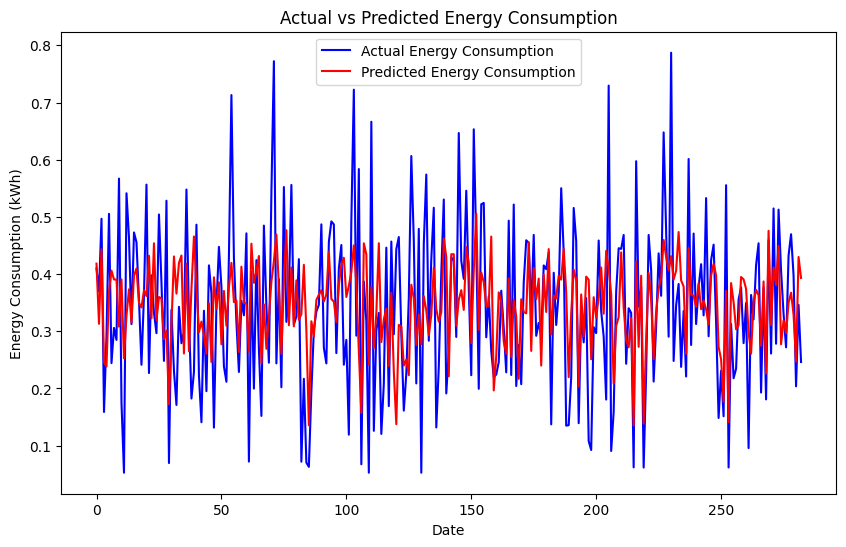

In [ ]:
Y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(Y_test, color='blue', label='Actual Energy Consumption')
plt.plot(Y_pred, color='red', label='Predicted Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()